In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

In [0]:
os.chdir('/content/drive/My Drive')

Source of the dataset: https://archive.ics.uci.edu/ml/datasets/online+retail

In [0]:
df = pd.read_excel('Online Retail.xlsx')

In [6]:
#Check if data is loaded
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
#Looking for null values and data types
df.info()
#Observations: some null values in description,customer id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df.groupby('Country')['InvoiceNo'].count()

Country
Australia                 1259
Austria                    401
Bahrain                     19
Belgium                   2069
Brazil                      32
Canada                     151
Channel Islands            758
Cyprus                     622
Czech Republic              30
Denmark                    389
EIRE                      8196
European Community          61
Finland                    695
France                    8557
Germany                   9495
Greece                     146
Hong Kong                  288
Iceland                    182
Israel                     297
Italy                      803
Japan                      358
Lebanon                     45
Lithuania                   35
Malta                      127
Netherlands               2371
Norway                    1086
Poland                     341
Portugal                  1519
RSA                         58
Saudi Arabia                10
Singapore                  229
Spain                     2533


In [9]:
#shape of the dataset
df.shape

(541909, 8)

In [0]:
#some of the descriptions have inter spaces that need to be removed
df['Description'] = df['Description'].str.strip()

In [11]:
#Looking for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540454 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [0]:
#Drop any new invoices which are null and convert it to a string
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

In [13]:
#shape of the dataset
df.shape

(541909, 8)

In [14]:
#Summary
df.describe(include='all')
#Observation: we find that the there are some negative quantities which relate to credit invoices. We need to drop those from our consideration in modelling
    

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540454,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4210,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [0]:
#We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions 
#(those with invoice numbers containing C).
#df = df[~df['InvoiceNo'].str.contains('C')]
#Removing all invoices that have negative quantities
df = df[df['Quantity']>0]

In [16]:
#shape of the dataset
df.shape

(531285, 8)

Text(0.5, 1.0, 'Most Bought Items')

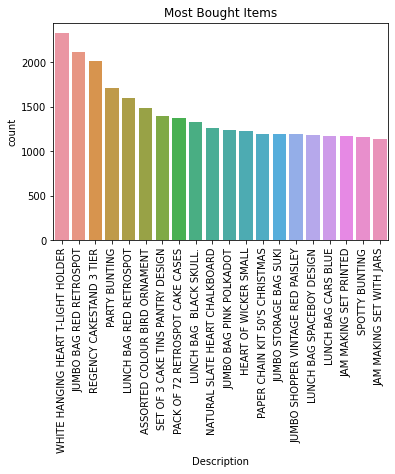

In [18]:
#Plot the most bought items
sns.countplot(x = 'Description', data = df, order = df['Description'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.title("Most Bought Items")

In [0]:
#Sales for Unite kingdom (to keep the data small)
basket = (df[df['Country'] =="United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [20]:
basket

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,...,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,add stock to allocate online orders,adjustment,alan hodge cant mamage this section,allocate stock for dotcom orders ta,amazon,amazon adjust,amazon sales,came coded as 20713,check,check?,damaged,did a credit and did not tick ret,dotcom,dotcom adjust,dotcomstock,for online retail orders,found,found box,had been put aside,incorrectly credited C550456 see 47,mailout,michel oops,on cargo order,rcvd be air temp fix for dotcom sit,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
#any positive values are converted to a 1 and anything less the 0 is set to 0.
#remove the postage column (since that charge is not one we wish to explore):
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [22]:
basket_sets

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,...,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,add stock to allocate online orders,adjustment,alan hodge cant mamage this section,allocate stock for dotcom orders ta,amazon,amazon adjust,amazon sales,came coded as 20713,check,check?,damaged,did a credit and did not tick ret,dotcom,dotcom adjust,dotcomstock,for online retail orders,found,found box,had been put aside,incorrectly credited C550456 see 47,mailout,michel oops,on cargo order,rcvd be air temp fix for dotcom sit,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581585,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A563185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.015005,(10 COLOUR SPACEBOY PEN)
1,0.013246,(12 MESSAGE CARDS WITH ENVELOPES)
2,0.017973,(12 PENCIL SMALL TUBE WOODLAND)
3,0.018633,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.018523,(12 PENCILS SMALL TUBE SKULL)
...,...,...
2126,0.010938,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU..."
2127,0.010443,"(LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA..."
2128,0.010938,"(LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA..."
2129,0.010168,"(LUNCH BAG BLACK SKULL., LUNCH BAG SPACEBOY D..."


In [24]:
rules = association_rules(frequent_itemsets,metric='lift',min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DOTCOM POSTAGE),(6 RIBBONS RUSTIC CHARM),0.038914,0.046994,0.011103,0.285311,6.071279,0.009274,1.333456
1,(6 RIBBONS RUSTIC CHARM),(DOTCOM POSTAGE),0.046994,0.038914,0.011103,0.236257,6.071279,0.009274,1.258390
2,(JAM MAKING SET PRINTED),(6 RIBBONS RUSTIC CHARM),0.055403,0.046994,0.011872,0.214286,4.559900,0.009268,1.212917
3,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET PRINTED),0.046994,0.055403,0.011872,0.252632,4.559900,0.009268,1.263898
4,(6 RIBBONS RUSTIC CHARM),(JAM MAKING SET WITH JARS),0.046994,0.054908,0.010608,0.225731,4.111061,0.008028,1.220625
...,...,...,...,...,...,...,...,...,...
4245,(CHARLOTTE BAG SUKI DESIGN),"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",0.044190,0.012751,0.010828,0.245025,19.215442,0.010264,1.307657
4246,(CHARLOTTE BAG PINK POLKADOT),"(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...",0.037045,0.013686,0.010828,0.292285,21.356750,0.010321,1.393660
4247,(RED RETROSPOT CHARLOTTE BAG),"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",0.049742,0.011707,0.010828,0.217680,18.593718,0.010245,1.263284
4248,(STRAWBERRY CHARLOTTE BAG),"(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",0.036990,0.013191,0.010828,0.292719,22.190552,0.010340,1.395215


In [26]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.5) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
24,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 60 PINK PAISLEY CAKE CASES),0.020391,0.042926,0.010388,0.509434,11.867659,0.009513,1.950958
26,(60 CAKE CASES DOLLY GIRL DESIGN),(PACK OF 72 RETROSPOT CAKE CASES),0.020391,0.062053,0.011212,0.549865,8.861159,0.009947,2.083702
45,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.041387,0.062053,0.022480,0.543161,8.753114,0.019912,2.053121
61,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.020886,0.048148,0.013686,0.655263,13.609427,0.012680,2.761098
65,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED),0.020886,0.051116,0.013961,0.668421,13.076616,0.012893,2.861714
...,...,...,...,...,...,...,...,...,...
4235,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...","(WOODLAND CHARLOTTE BAG, RED RETROSPOT CHARLOT...",0.021106,0.016764,0.010828,0.513021,30.602954,0.010474,2.019052
4237,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...","(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",0.021601,0.016489,0.010828,0.501272,30.400492,0.010472,1.972040
4240,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...","(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...",0.019897,0.017313,0.010828,0.544199,31.432237,0.010483,2.155955
4241,"(CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOT...","(RED RETROSPOT CHARLOTTE BAG, STRAWBERRY CHARL...",0.019622,0.017698,0.010828,0.551821,31.179585,0.010480,2.191761
